In [2]:
import os
import logging
import time
import threading
from glob import glob
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import pmdarima as pm
import plotly.express as px
import shap

from arch import arch_model
from scipy.stats import norm
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.utils import resample

import chromedriver_autoinstaller
from tqdm import tqdm

# Are Watches a wise Investment? 
This is the central question that our analysis seeks to address. Our goal is to provide insights that are not only intriguing but also practically beneficial for you, the reader. We hope that you find the analysis informative and that it aids in your understanding of the potential investment value of watches. Enjoy exploring our findings!

Best regards, Riccardo Pondini 

# EXTRACTING WATCHES DATA AND CREATING THE DATAFRAME
This script, developed for data acquisition and processing from "watchpricetrend.com", performs several key operations using Selenium. Firstly, it configures logging to display only critical messages. The script sets up the Chrome browser with Selenium, using an automatically installed ChromeDriver, and specifies a download directory on the user's desktop specifically for storing exported watch data. The main function navigates to the target URL, waits for the page to fully load, then retrieves and processes links to watch detail pages, excluding the first five because they don't represent watch models. Each link is accessed to click through the UI and export data in CSV format.

Additionally, the script utilizes multithreading to handle multiple downloads concurrently, ensuring efficient data retrieval. After collecting the data, another function consolidates all CSV files into a single DataFrame. This DataFrame is scrutinized to ensure all files include two columns with one as a date column, which is then converted and set as the index. It handles NaN values intelligently, filling gaps with the nearest data points or dropping columns with excessive missing data, and finally, it excludes the last row if its date significantly deviates from others. The end result is a comprehensive time series DataFrame, ready for further analysis or reporting.

In [4]:
# Initialize logging
logging.basicConfig(level=logging.CRITICAL)

# Install ChromeDriver
path_to_chromedriver = chromedriver_autoinstaller.install()

# Configure download folder
home_directory = os.path.expanduser("~")
desktop_path = os.path.join(home_directory, 'Desktop')

# Check if Desktop exists, otherwise handle possible localization
if not os.path.exists(desktop_path):
    raise Exception("Desktop path not found. Please specify the correct path.")

new_folder_name = 'Watches time series'
download_folder = os.path.join(desktop_path, new_folder_name)
os.makedirs(download_folder, exist_ok=True)

# Function that configures and launches Chrome for automated downloads.
def setup_driver(download_folder):
    options = webdriver.ChromeOptions()
    options.add_experimental_option("prefs", {
        "download.default_directory": download_folder,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "safebrowsing.enabled": True
    })
    service = Service(path_to_chromedriver)
    driver = webdriver.Chrome(service=service, options=options)
    return driver

# Function that automates navigating to a URL and exporting data as a CSV file (it uses webdriver to wait for the buttons to be clickable)
def export_csv_from_page(driver, detail_url):
    try:
        driver.get(detail_url)
        WebDriverWait(driver, 5).until(
            EC.visibility_of_element_located((By.CLASS_NAME, "amcharts-export-menu-bottom-right")))
        WebDriverWait(driver, 5).until(
            EC.invisibility_of_element((By.ID, "loading")))
        # Additional checks for any overlays
        WebDriverWait(driver, 5).until(
            EC.invisibility_of_element((By.CSS_SELECTOR, ".ajs-modal")))
        WebDriverWait(driver, 5).until(
            EC.invisibility_of_element((By.CSS_SELECTOR, "ul.popup-menu, .modal-backdrop")))
        time.sleep(1)
        WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "amcharts-export-menu-bottom-right")))
        export_button = driver.find_element(By.CLASS_NAME, "amcharts-export-menu-bottom-right")
        export_button.click()
        time.sleep(0.1)
        WebDriverWait(driver, 5).until(
            EC.visibility_of_element_located((By.XPATH, "//a[span/text()='Save as ...']")))
        save_as_button = driver.find_element(By.XPATH, "//a[span/text()='Save as ...']")
        save_as_button.click()
        time.sleep(0.1)
        WebDriverWait(driver, 5).until(
            EC.visibility_of_element_located((By.XPATH, "//a[span/text()='CSV']")))
        csv_button = driver.find_element(By.XPATH, "//a[span/text()='CSV']")
        csv_button.click()

        logging.info(f"Completed export for link: {detail_url}")
        time.sleep(2)  # Minimum sleep time to avoid hitting the rate limit
    
    except Exception as e:
        logging.error(f"Error during export for {detail_url}: {e}")

# Function that automates CSV downloads for a list of URLs
def thread_function(urls):
    driver = setup_driver(download_folder)
    for url in urls:
        export_csv_from_page(driver, url)
    driver.quit()

# Main execution block
if __name__ == "__main__":
    driver = setup_driver(download_folder)  # Proper initialization of the driver
    try:
        base_url = "https://www.watchpricetrend.com"
        url = urljoin(base_url, "/cost/")
        driver.get(url)

        WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.ID, "footer")))
        logging.info("The page has fully loaded.")

                # Find all the links on the page
        links = driver.find_elements(By.XPATH, "//li/a")
        
        # Create a list of detail URLs, skipping the first 5 non-watch model links
        detail_urls = [urljoin(base_url, link.get_attribute('href')) for link in links if link.get_attribute('href')]
        detail_urls = detail_urls[5:]
        
        # Check if there are any detail links found
        if not detail_urls:
            logging.error("No detail links found")
        else:
            # Set the maximum number of threads allowed to avoid exceeding the rate limit
            num_threads = 4
            threads = []
            urls_per_thread = len(detail_urls) // num_threads
            
            # Distribute the URLs among the threads and start them
            for i in range(num_threads):
                thread_urls = detail_urls[i * urls_per_thread:(i + 1) * urls_per_thread]
                t = threading.Thread(target=thread_function, args=(thread_urls,))
                threads.append(t)
                t.start()
            
            # Wait for all threads to finish
            for t in threads:
                t.join()
    finally:
        driver.quit()

# Function that merges all the individual data togheter
def merge_csv_files(download_folder):
    # Using the package glob to read all the files in the folder
    csv_files = glob(os.path.join(download_folder, "*.csv"))
    df_list = []

    for file in csv_files:
        df = pd.read_csv(file)
        # Check that there are exactly two columns and that one is 'date'
        if len(df.columns) == 2 and 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'] + '-0', format='%Y-%W-%w')
            df.set_index('date', inplace=True)
            df_list.append(df)
        else:
            print(f"Skipped: {file} - Does not meet the column requirements.")
    # Use pd.concat to merge the DataFrames along the column axis
    if df_list:
        combined_df = pd.concat(df_list, axis=1)
        return combined_df
    else:
        print("No valid data to merge.")
        return pd.DataFrame()

# Merging the data
combined_df = merge_csv_files(download_folder)

# Function that manages NaN values
def fill_with_nearest_advanced(df):
    for col in df.columns:
        # Count consecutive NaNs
        nan_groups = df[col].isna().astype(int).groupby(df[col].notna().cumsum()).cumsum()

        # If a column has more than three consecutive NaNs, remove it
        if nan_groups.max() > 3:
            df.drop(col, axis=1, inplace=True)
        else:
            # Fill the Nan with the closest non_NaN value
            for idx in df[col][df[col].isna()].index:
                prev_value = df[col][:idx].dropna().iloc[-1] if not df[col][:idx].dropna().empty else np.nan
                next_value = df[col][idx:].dropna().iloc[0] if not df[col][idx:].dropna().empty else np.nan
                
                # Handling cases where either previous or next values are NaN 
                if pd.isna(prev_value):
                    df.at[idx, col] = next_value
                elif pd.isna(next_value):
                    df.at[idx, col] = prev_value
                else:
                    prev_distance = idx - df[col][:idx].dropna().index[-1]
                    next_distance = df[col][idx:].dropna().index[0] - idx
                    # Assign the closest non-NaN value based on the distance
                    df.at[idx, col] = prev_value if prev_distance <= next_distance else next_value

    return df

# New dataframe with corrected NaNs
combined_df = fill_with_nearest_advanced(combined_df)

# Drop the last row as the date is too distant from the others
combined_df = combined_df.drop(combined_df.index[-1])

# UNIVARIATE ANALYSIS: Optimizing Watch Investments
In this section of our analysis, we focus on identifying the top-performing watches from our dataset based on two key financial metrics: highest average returns and lowest variance. The average return is a crucial measure as it indicates the typical gain or loss that an investment is expected to generate over a period. A higher average return is desirable as it suggests a greater potential profit.

Conversely, variance in returns measures the consistency of these returns. A lower variance indicates that the watch prices are relatively stable, which is often considered a marker of lower investment risk.

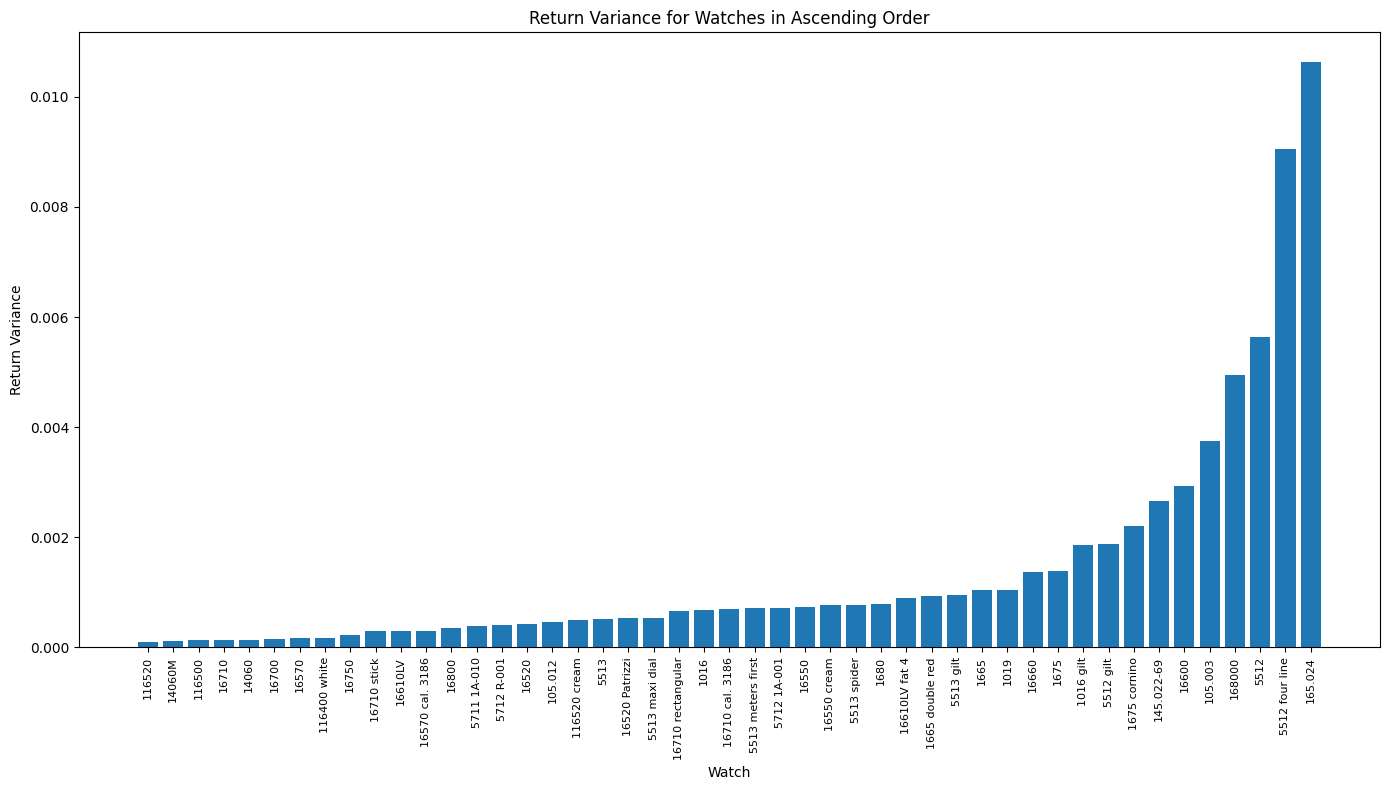

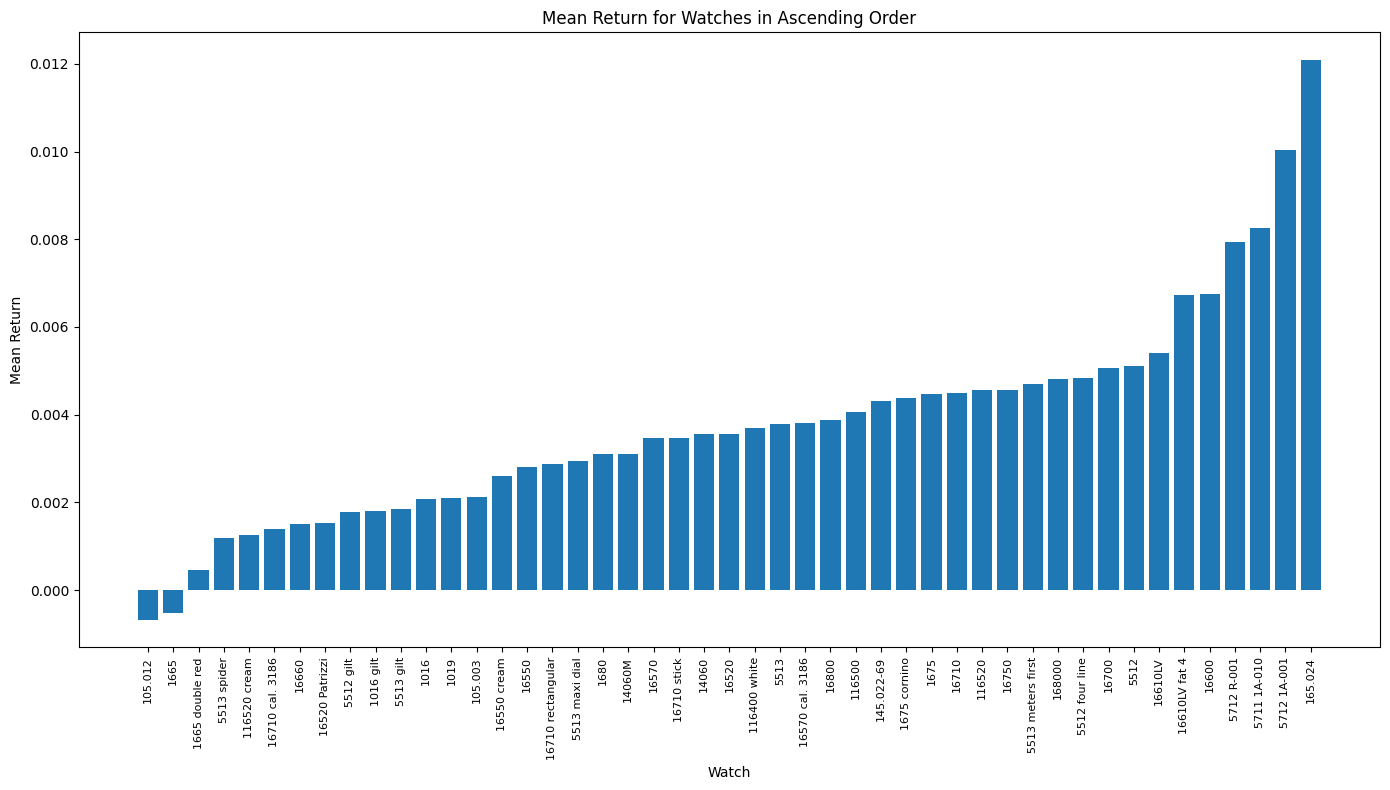

The best three watches in returns terms are: 5711 1A-010, 5712 1A-001, 165.024
The best three watches in terms of lowest variance are: 116520, 14060M, 116500


In [7]:
# Calculate daily percentage returns for each watch
returns_df = combined_df.pct_change().dropna()

# Calculate the variance and mean of returns for each watch
variance_series = returns_df.var()
mean_series = returns_df.mean()

# Build a DataFrame for returns and variances
summary_df = pd.DataFrame({
    'Mean Return': mean_series,
    'Return Variance': variance_series
})

# Sort the DataFrame by return variance in ascending order
summary_df_sorted_variance = summary_df.sort_values(by='Return Variance')

# Create a bar chart for the variances
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(summary_df_sorted_variance.index, summary_df_sorted_variance['Return Variance'])
ax.set_xlabel('Watch')
ax.set_ylabel('Return Variance')
ax.set_title('Return Variance for Watches in Ascending Order')
labels = summary_df_sorted_variance.index
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=8)
plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

# Sort the DataFrame by mean returns in ascending order
summary_df_sorted_mean = summary_df.sort_values(by='Mean Return')

# Create a bar chart for the mean returns
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(summary_df_sorted_mean.index, summary_df_sorted_mean['Mean Return'])
ax.set_xlabel('Watch')
ax.set_ylabel('Mean Return')
ax.set_title('Mean Return for Watches in Ascending Order')
labels = summary_df_sorted_mean.index
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=8)
plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

# Extract the top three watches based on mean return and lowest variance
top_three_watches = summary_df_sorted_mean.tail(3)
top_three_low_variance = summary_df_sorted_variance.head(3)

# Print results
print(f"The best three watches in returns terms are: {', '.join(top_three_watches.index)}")
print(f"The best three watches in terms of lowest variance are: {', '.join(top_three_low_variance.index)}")

# ARIMA/GARCH Model Analysis on Composite Watch Index
In this section, we delve into the dynamics and forecast the behavior of watch prices using sophisticated statistical models centered on a comprehensive index that aggregates all watches in our dataset.

We employ the ARIMA (AutoRegressive Integrated Moving Average) model to analyze and predict future values of the watch index based on its historical data. This model integrates an AutoRegressive component that utilizes past values, an Integrated part which ensures the series is stationary through differencing, and a Moving Average aspect that models the error terms. This model is crucial for identifying patterns and trends in the time series, helping to project future movements in the index.

Additionally, when dealing with data that exhibits seasonal patterns, we extend our ARIMA model to a Seasonal ARIMA (SARIMA) model. SARIMA specifically addresses seasonality by including several seasonal elements: Seasonal AR term (P) reflects the number of seasonal lag observations; Seasonal differencing (D) represents the number of times the seasonal observations are differenced; Seasonal MA term (Q) corresponds to the moving average components for the seasonal lag; Seasonal Period Length (S) specifies the length of the seasonal cycle, enabling the model to account for seasonality effectively.

Following the trend analysis with ARIMA and SARIMA, we employ the GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model to examine the volatility of the index. The GARCH model is invaluable in financial time series where volatility clustering is common, as it provides deep insights into the risk levels associated with investments in watches. This dual-model approach ensures a comprehensive analysis, offering predictions on both the directional trends and the volatility of the watch index, thereby aiding investors in making well-informed decisions regarding their watch portfolio.

This comprehensive modeling approach not only helps in understanding the current dynamics but also provides a robust framework for predicting future price movements and assessing risks, thereby facilitating strategic investment decisions in the watch market.

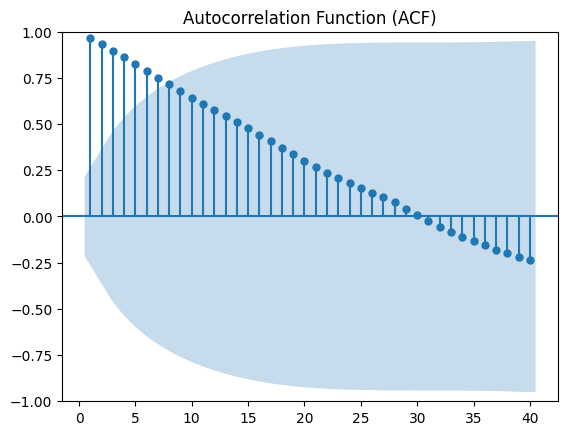

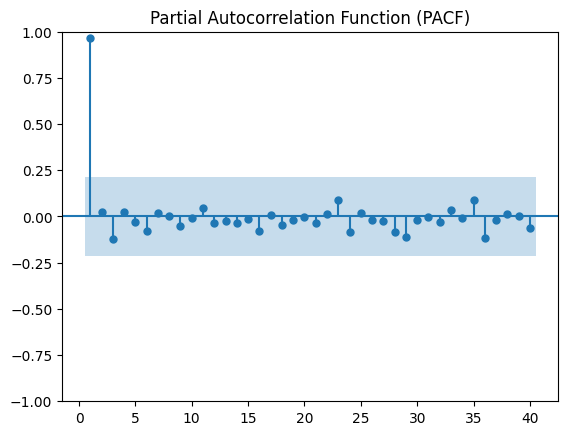

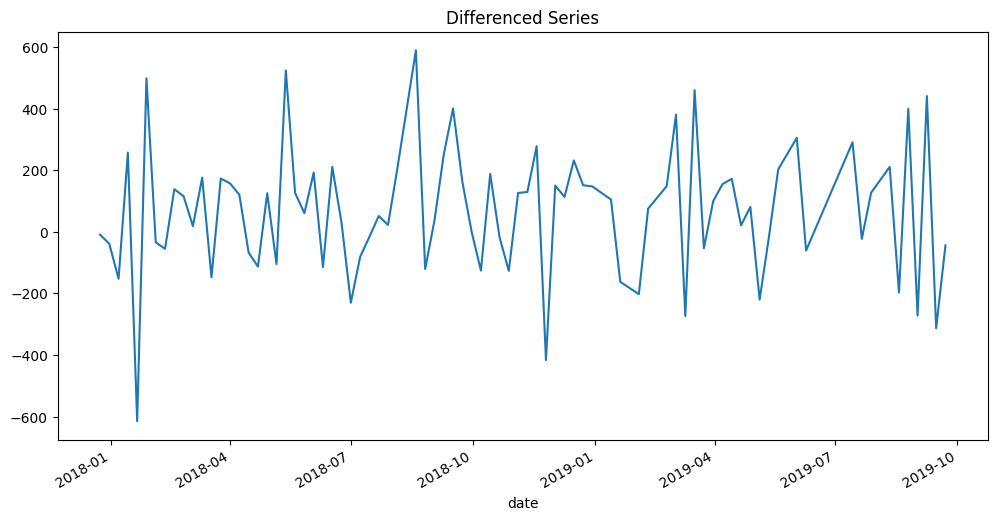

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1025.681, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=973.047, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=973.770, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=970.135, Time=0.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1021.653, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=962.967, Time=0.14 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=967.501, Time=0.05 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=963.107, Time=0.13 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=0.

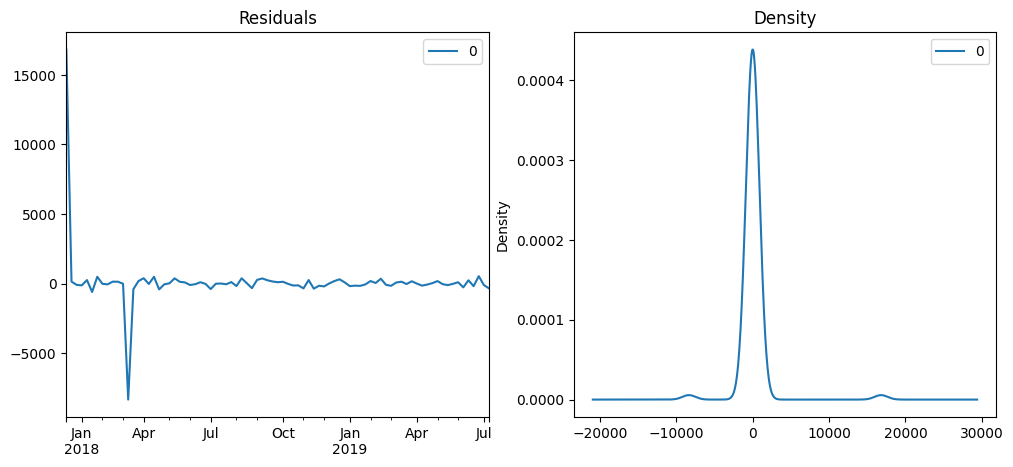

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                255.273
Distribution:                  Normal   AIC:                          -502.545
Method:            Maximum Likelihood   BIC:                          -492.919
                                        No. Observations:                   82
Date:                Sun, Jul 21 2024   Df Residuals:                       81
Time:                        16:10:31   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.9370e-03  1.025e-03      2.865  4.170e-03 [9.

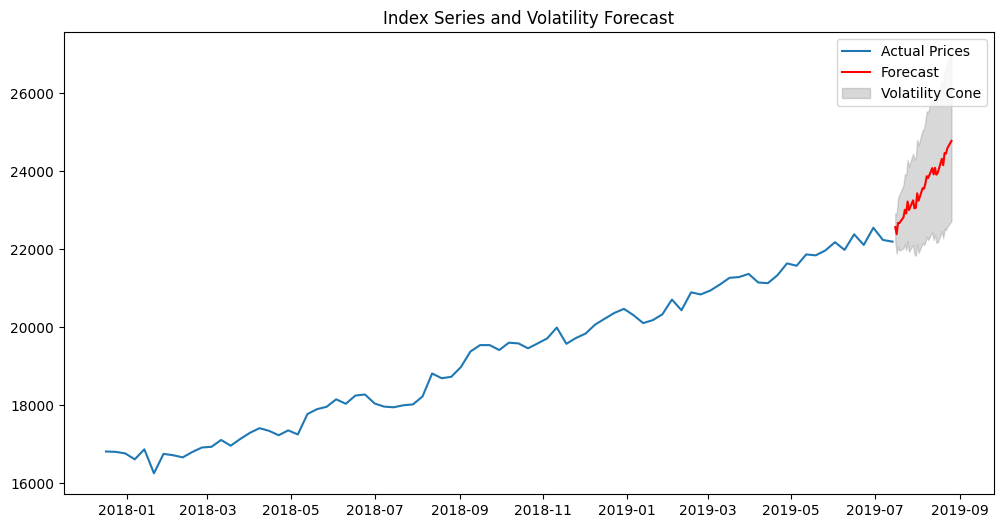

In [8]:
# Creation of an index of all the watches by using averages
index_series = combined_df.mean(axis=1)
combined_df['index'] = index_series

# Plot ACF and PACF for index_series
plot_acf(index_series, lags=40, zero=False)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(index_series, lags=40, zero=False)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Make the time series stationary through differencing and setting the frequency
index_diff = index_series.diff().dropna()
index_series.index = pd.date_range(start='2017-12-17', periods=len(index_series), freq='W-SUN')

# Display the differenced time series
index_diff.plot(figsize=(12, 6))
plt.title('Differenced Series')
plt.show()

# Fit stepwise auto-ARIMA using the differenced series (it finds the best parameters for the specific data)
stepwise_fit = pm.auto_arima(index_diff, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

# Train the ARIMA model
p, d, q = stepwise_fit.order
P, D, Q, S = stepwise_fit.seasonal_order

# Fit the ARIMA model to the index series
arima_model = ARIMA(index_series, order=(p, d, q), seasonal_order=(P, D, Q, S))
results = arima_model.fit()

# Print model summary
print(results.summary())

# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
residuals.plot(title="Residuals", figsize=(12, 5), ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Make predictions with the trained model
forecast_steps = 30
forecast_index = pd.date_range(start=index_series.index[-1], periods=forecast_steps + 1, freq='B')[1:]
forecast_index = pd.DatetimeIndex(forecast_index)
forecast = results.get_forecast(steps=forecast_steps, index=forecast_index)
forecast_mean = forecast.predicted_mean

# Calculate returns for GARCH model
returns = index_series.pct_change().dropna()

# Fit the GARCH model
best_aic = np.inf
best_model = None

for p in range(1, 4):
    for q in range(1, 4):
        model = arch_model(returns, p=p, q=q, rescale=False)
        res = model.fit(disp='off')
        if res.aic < best_aic:
            best_aic = res.aic
            best_model = res

garch_model = best_model
print(garch_model.summary())

# Calculate the forecasted volatility
forecast = garch_model.forecast(horizon=forecast_steps, start=None)
volatility_scalar = forecast.variance.iloc[-1].iloc[0] ** 0.5
print(volatility_scalar)

# Calculate the volatility bands for the forecasted values
last_price = index_series.iloc[-1]
future_dates = pd.date_range(start=index_series.index[-1], periods=forecast_steps + 1, freq='B')[1:]
upper_band_forecast = forecast_mean * np.exp(volatility_scalar * 1.64 * np.sqrt(np.arange(1, forecast_steps + 1)))
lower_band_forecast = forecast_mean * np.exp(-volatility_scalar * 1.64 * np.sqrt(np.arange(1, forecast_steps + 1)))

# Visualize the forecasts
plt.figure(figsize=(12, 6))
plt.plot(index_series.index, index_series, label='Actual Prices')
plt.plot(forecast_index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_index, lower_band_forecast, upper_band_forecast, color='gray', alpha=0.3, label='Volatility Cone')
plt.title('Index Series and Volatility Forecast')
plt.legend()
plt.show()

# Multivariate Analysis: Watches, Gold, Oil, S&P 500 and VIX

This section explores the relationship between the watch investment index and key economic indicators: gold prices, crude oil prices, the S&P 500 and the index of volatility VIX. This approach not only aids in identifying risk factors but also in spotting opportunities where watch investments might yield favorable returns amidst varying economic conditions. Through this detailed multivariate analysis, investors can make informed decisions by considering not just the internal metrics of watch price movements but also the external economic environment that surrounds them.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


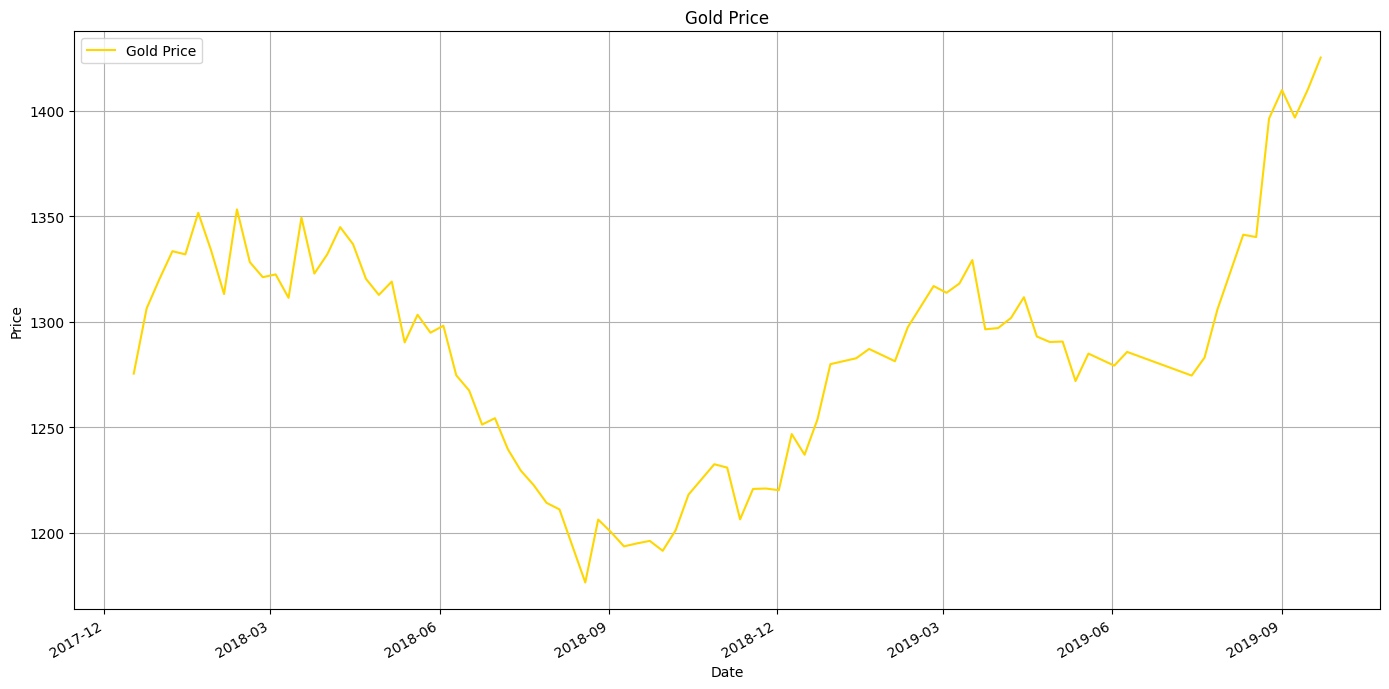

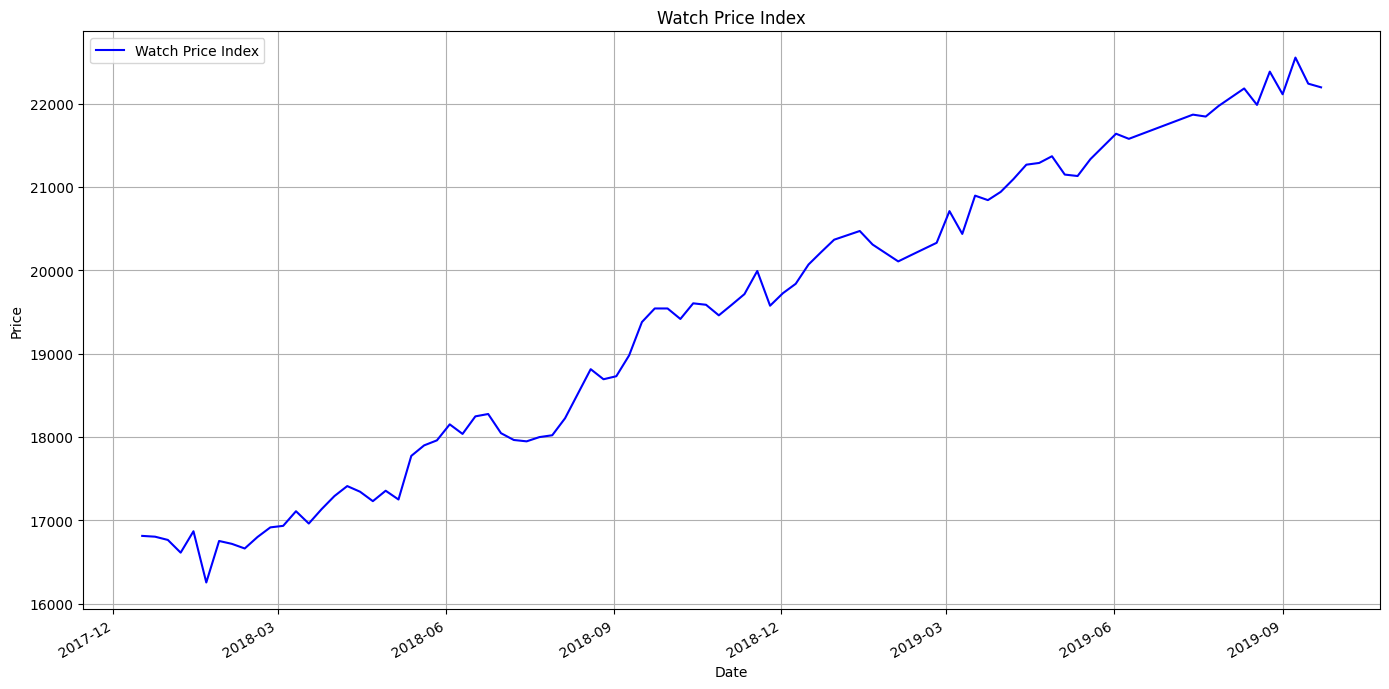

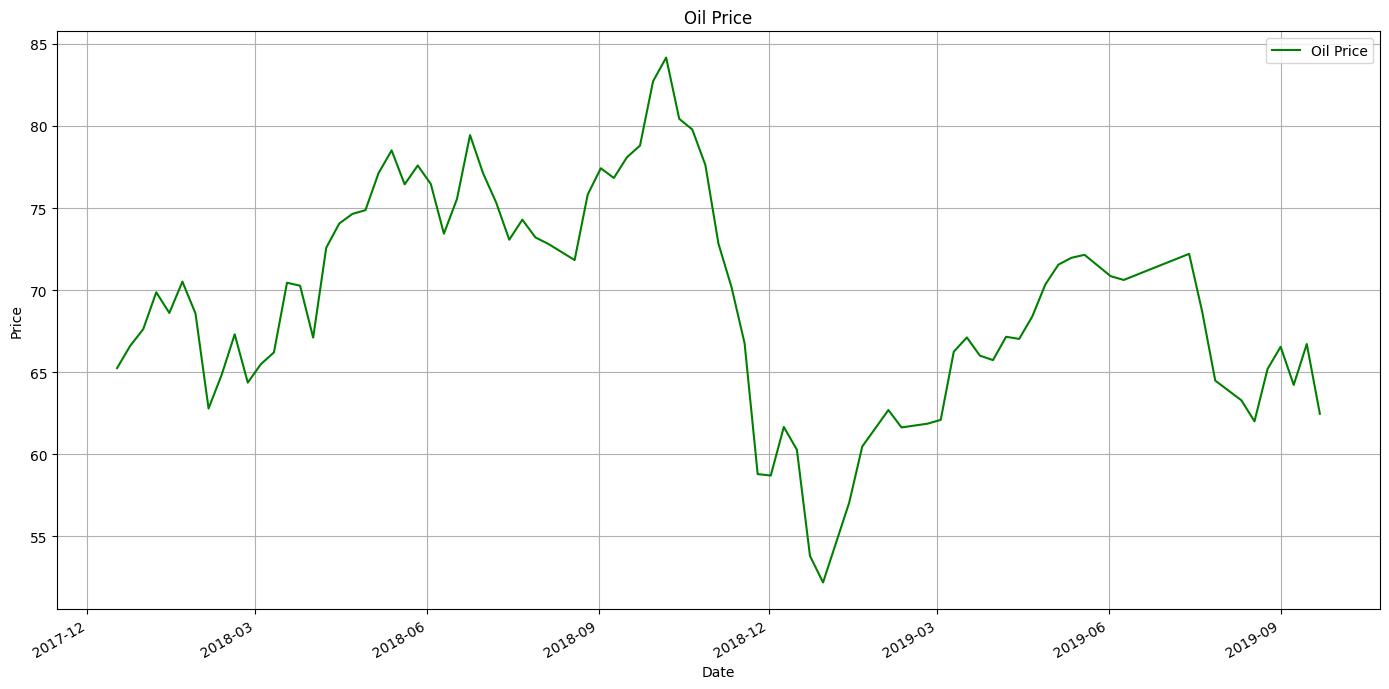

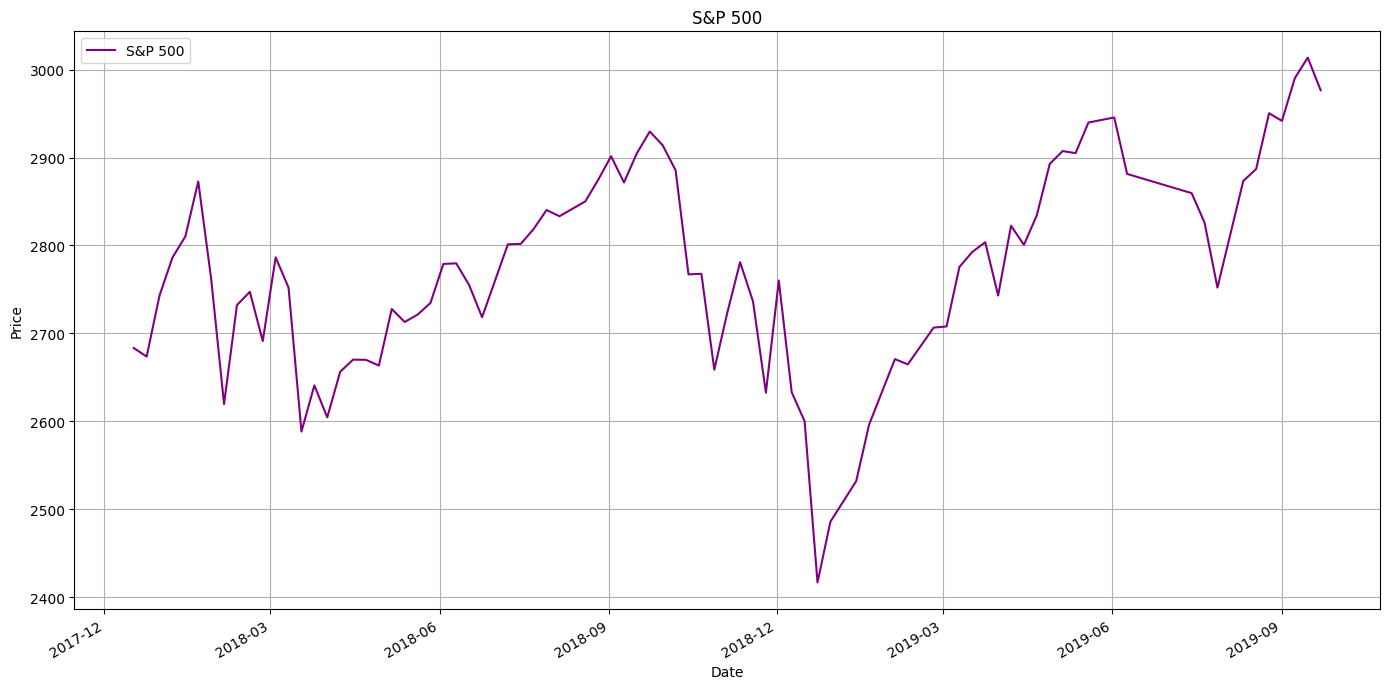

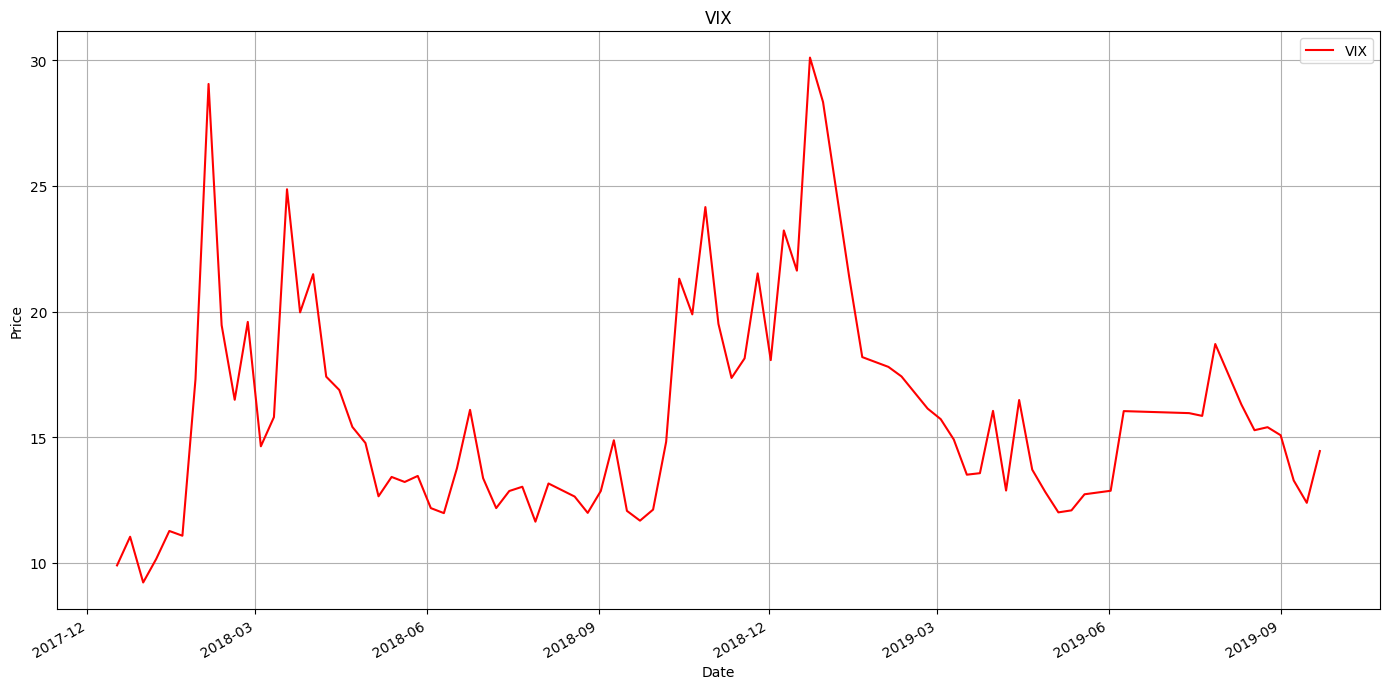

In [10]:
# Define the start and end dates
start_date = "2017-12-17"
end_date = "2019-09-22"

# Downloading gold historical data
gold_data = yf.download("GC=F", start=start_date, end=end_date, interval="1wk")
gold_adj_close = gold_data[['Adj Close']].rename(columns={'Adj Close': 'Gold Price'})

# Historical data Brent crude Oil 
oil_data = yf.download("BZ=F", start=start_date, end=end_date, interval="1wk")
oil_adj_close = oil_data[['Adj Close']].rename(columns={'Adj Close': 'Oil Price'})

# Historical data SP 500
sp500_data = yf.download("^GSPC", start=start_date, end=end_date, interval="1wk")
sp500_adj_close = sp500_data[['Adj Close']].rename(columns={'Adj Close': 'SP500'})

# Historical data VIX
vix_data = yf.download("^VIX", start=start_date, end=end_date, interval="1wk")
vix_adj_close = vix_data[['Adj Close']].rename(columns={'Adj Close': 'VIX'})

# Ensure all DataFrames have the same length
min_length = min(len(combined_df), len(gold_adj_close), len(oil_adj_close), len(sp500_adj_close), len(vix_adj_close))

# Truncate all DataFrames to the same length and align indices
combined_df_2 = combined_df.iloc[:min_length]
gold_adj_close = gold_adj_close.iloc[:min_length].set_index(combined_df.index)
oil_adj_close = oil_adj_close.iloc[:min_length].set_index(combined_df.index)
sp500_adj_close = sp500_adj_close.iloc[:min_length].set_index(combined_df.index)
vix_adj_close = vix_adj_close.iloc[:min_length].set_index(combined_df.index)

# Merge DataFrames
merged_df = combined_df_2.join(gold_adj_close, how='inner')
merged_df = merged_df.join(oil_adj_close, how='inner')
merged_df = merged_df.join(sp500_adj_close, how='inner')
merged_df = merged_df.join(vix_adj_close, how='inner')

# Define the configurations for each graph in a list of dictionaries
graphs = [
    {'column': 'Gold Price', 'color': 'gold', 'title': 'Gold Price'},
    {'column': 'index', 'color': 'blue', 'title': 'Watch Price Index'},
    {'column': 'Oil Price', 'color': 'green', 'title': 'Oil Price'},
    {'column': 'SP500', 'color': 'purple', 'title': 'S&P 500'},
    {'column': 'VIX', 'color': 'red', 'title': 'VIX'}
]

# Loop to create each graph.
for graph in graphs:
    plt.figure(figsize=(14, 7))
    plt.plot(merged_df.index, merged_df[graph['column']], label=graph['title'], color=graph['color'])
    plt.title(graph['title'])
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Correlation Heatmap Analysis

This analysis explores the relationships between the watch index and key economic indicators—gold price, crude oil price, the S&P 500, and the VIX—using a correlation heatmap. The visualization illustrates how these variables interact with the watch market.

The heatmap indicates a moderate positive correlation between the watch index and the S&P 500, suggesting that watch prices often move in tandem with broader stock market trends. This correlation implies that, as luxury items, watches may be responsive to the overall economic climate reflected by the stock market. Conversely, the connections between the watch index and both gold and oil prices are weaker, indicating that these commodities have a limited direct influence on watch prices. This could suggest that the watch market operates with a degree of independence from these commodity markets, or other factors may override the influence of gold and oil prices.

The minimal correlation with the VIX highlights that general market volatility does not strongly impact watch prices directly, suggesting stability in the luxury watch market even amid broader financial market fluctuations. However, it's important to note that Pearson's correlation may not fully capture the relationship if it's non-linear. Although the VIX shows minimal direct correlation, its real impact on watch prices, which could be non-linear, might be underestimated. Furthermore, the heatmap emphasizes the well-known inverse relationship between the VIX and the S&P 500, where increases in market volatility often correspond with declines in stock market performance. This relationship is crucial as it frames the broader economic environment in which the watch market operates.

This correlation analysis reveals the complex and varied nature of the relationships between the watch index and these economic indicators. It underscores that while the stock market may influence watch prices, other economic factors like gold and oil prices, and market volatility, play lesser roles. This insight is invaluable for investors looking to understand the dynamics that might impact their watch investments amid changing economic conditions.

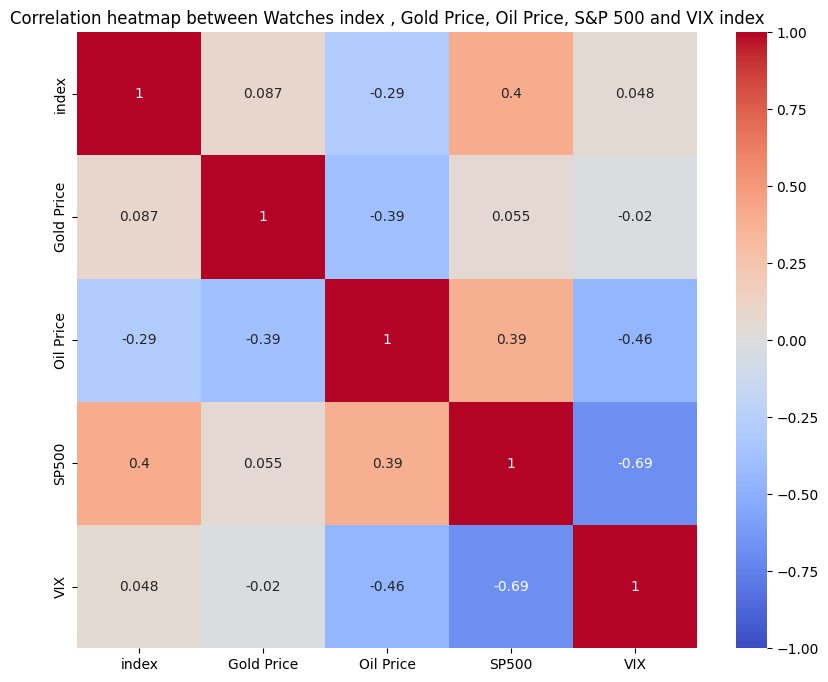

In [12]:
correlation_matrix_all = merged_df[['index', 'Gold Price', 'Oil Price', 'SP500', 'VIX']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation heatmap between Watches index , Gold Price, Oil Price, S&P 500 and VIX index')
plt.show()

# Monte Carlo Simulations for Portfolio Analysis

In this section, we utilize Monte Carlo simulations to assess the performance of three distinctly weighted investment portfolios, with 1000 simulations run for each configuration. This method allows us to gauge the range of possible returns and the associated risks, providing a statistical foundation for informed investment decision-making.

The first portfolio is conservative, heavily weighted towards gold (40%), using its stability to mitigate risks during volatile market conditions. The second portfolio is evenly distributed across gold, oil, the S&P 500, and watches, aiming for a balanced risk-reward strategy. The third portfolio is aggressively oriented towards stocks (S&P 500) and watches (40% each), seeking higher returns by embracing potentially higher risks. Each portfolio's performance is simulated over a period equivalent to 52 weeks, starting with an initial investment of $100,000. The simulation incorporates the historical mean returns and covariance of the assets' weekly percentage changes to project future portfolio values.

The Cholesky decomposition of the covariance matrix is used to simulate correlated returns, maintaining the historical correlation structure. Portfolio values are projected daily and accumulated to estimate growth. Visualizations include the trajectory of portfolio values over time and the distribution of final values across all simulations, overlaid with a normal distribution fit to highlight the expected range and variability. Annotations for the mean final value provide quick statistical insights.

These visualizations and the detailed simulation approach help highlight the impacts of different asset classes—including watches, gold, oil, and the S&P 500—on overall portfolio performance. If results show that the third portfolio achieves a higher average return, it could represent a preferable option for those willing to accept greater risk in pursuit of higher rewards.

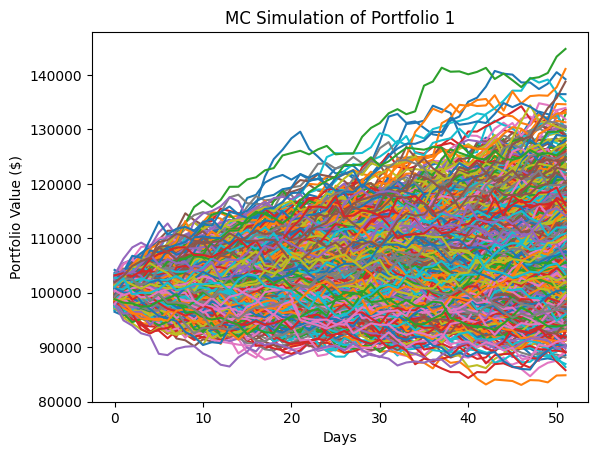

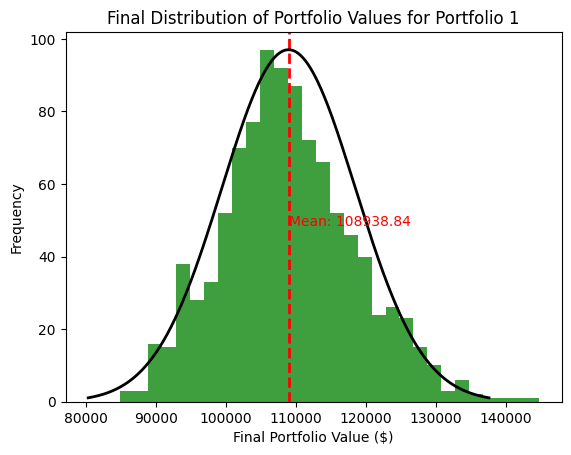

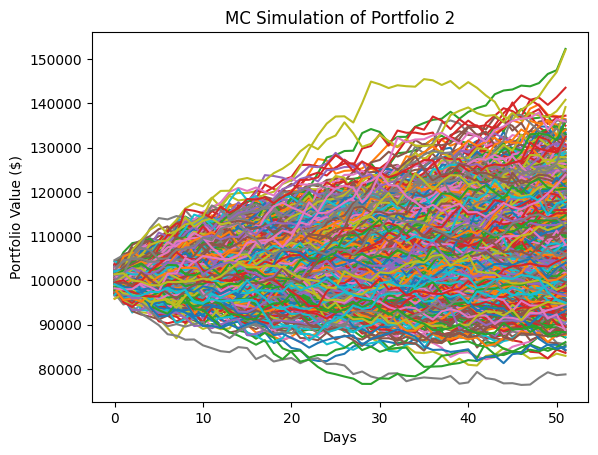

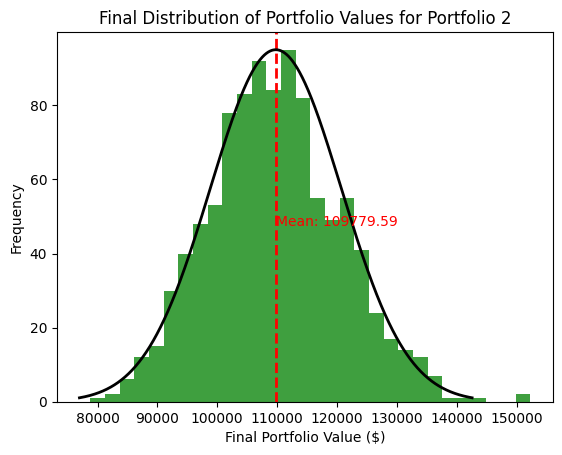

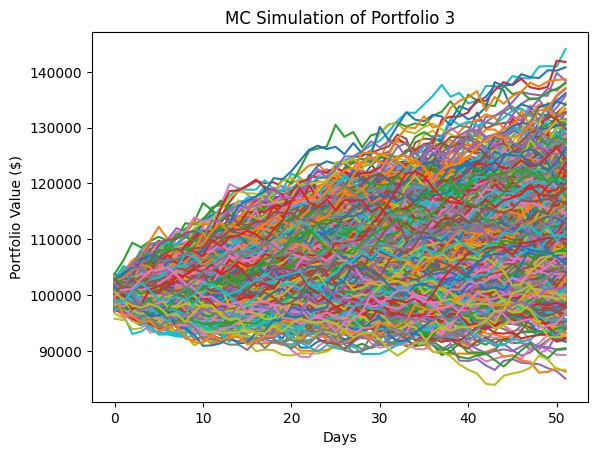

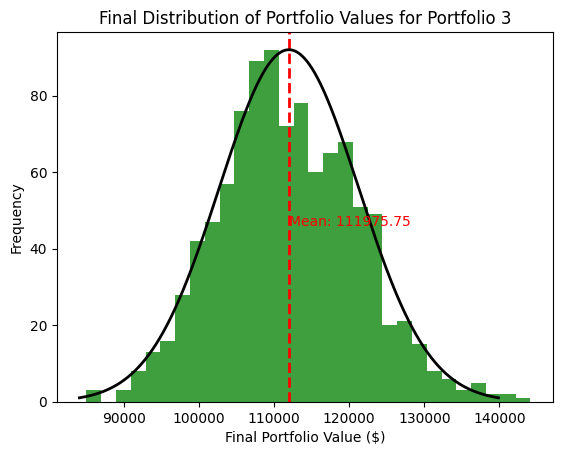

In [14]:
# Selecting only relevant columns
financial_assets = merged_df[['Gold Price', 'Oil Price', 'SP500', 'index']]

# Calculate daily percentage returns for each asset
returns = financial_assets.pct_change().dropna()

# Calculate the mean returns and covariance matrix
meanReturns = returns.mean()
covMatrix = returns.cov()

# Define weights for three different portfolios
portfolios = {
    'Portfolio 1': [0.40, 0.20, 0.20, 0.20],
    'Portfolio 2': [0.25, 0.25, 0.25, 0.25],
    'Portfolio 3': [0.10, 0.10, 0.40, 0.40]
}

# Monte Carlo simulations setup
mc_sims = 1000  # number of simulations
T = min(52, len(returns))  # Timeframe in weeks
initialPortfolio = 100000

# For each defined portfolio, convert the list of asset weights into a NumPy array.
for portfolio_name, weights in portfolios.items():
    weights = np.array(weights)
    
    # Initialize meanM to be (T, number of assets)
    meanM = np.tile(meanReturns.values, (T, 1))
    
    # Cholesky decomposition for the covariance matrix
    # This step decomposes the covariance matrix into a lower triangular matrix,
    # which is used to generate correlated random variables during the simulation.
    # This ensures that the simulated returns maintain the same correlation structure as the historical data.
    L = np.linalg.cholesky(covMatrix)

    # Create a matrix to store simulation results
    portfolio_sims = np.zeros((mc_sims, T))

    for m in range(mc_sims):
        # Generate Z, the matrix that gives randomness to the simulations
        Z = np.random.normal(size=(T, len(weights)))

        # Daily returns simulation
        dailyReturns = meanM + np.dot(Z, L.T)

        # Calculate cumulative product of returns
        portfolio_returns = np.cumprod(1 + np.dot(dailyReturns, weights), axis=0) * initialPortfolio
        portfolio_sims[m, :] = portfolio_returns

    # Plot the results
    plt.figure()
    plt.plot(portfolio_sims.T)  
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Days')
    plt.title(f'MC Simulation of {portfolio_name}')
    plt.show()

    # Histogram of the final values across all simulations. The overlaid line shows the normal distribution fit,
    # providing insights into the expected range and variability of portfolio outcomes.
    final_values = portfolio_sims[:, -1]  
    plt.figure()
    count, bins, ignored = plt.hist(final_values, bins=30, alpha=0.5, color='green')
    mean_final = np.mean(final_values)
    std_final = np.std(final_values)
    plt.axvline(mean_final, color='red', linestyle='dashed', linewidth=2)
    x = np.linspace(mean_final - 3 * std_final, mean_final + 3 * std_final, 1000)
    p = norm.pdf(x, mean_final, std_final)
    peak_histogram = max(count)  
    peak_pdf = max(p)  
    # Scale factor for the normal curve
    scale_factor = peak_histogram / peak_pdf  
    
    # Plotting the normal distribution
    plt.plot(x, p * scale_factor, 'k', linewidth=2)
    plt.text(mean_final, max(plt.hist(final_values, bins=30, alpha=0.5, color='green')[0])/2, f'Mean: {mean_final:.2f}', color='red')
    plt.title(f'Final Distribution of Portfolio Values for {portfolio_name}')
    plt.xlabel('Final Portfolio Value ($)')
    plt.ylabel('Frequency')
    plt.show()

# Vector Autoregression (VAR) Model Analysis

In this section, we apply a VAR model to time series data that has been differenced to ensure stationarity, a crucial requirement for model accuracy. The data includes Gold Price, Oil Price, S&P 500 Index, the watches index, and the VIX volatility index. After differencing and preparing the data, we reindexed it on a weekly frequency to ensure continuity and completeness of the time series.

Once the stationarity of each series was confirmed via the ADF test, we fitted the VAR model, choosing up to 12 lags representing a 3 months timespan. We then conduct a detailed analysis using the impulse-response approach to explore how shocks to one financial variable affect others within our system. This method involves introducing a standard deviation shock to one variable and observing its impact on the other variables over time. The results are visualized with confidence intervals of 95%, helping us understand the dynamic interactions and stability of these financial markets. We expect the effects of shocks to diminish progressively, converging towards zero as time progresses, reflecting the transient nature of economic shocks.

Gold Price stationarity p-value: 0.001249 -> Stationary
Oil Price stationarity p-value: 2.814e-11 -> Stationary
SP500 stationarity p-value: 8.737e-17 -> Stationary
index stationarity p-value: 6.415e-05 -> Stationary
VIX stationarity p-value: 0.004768 -> Stationary


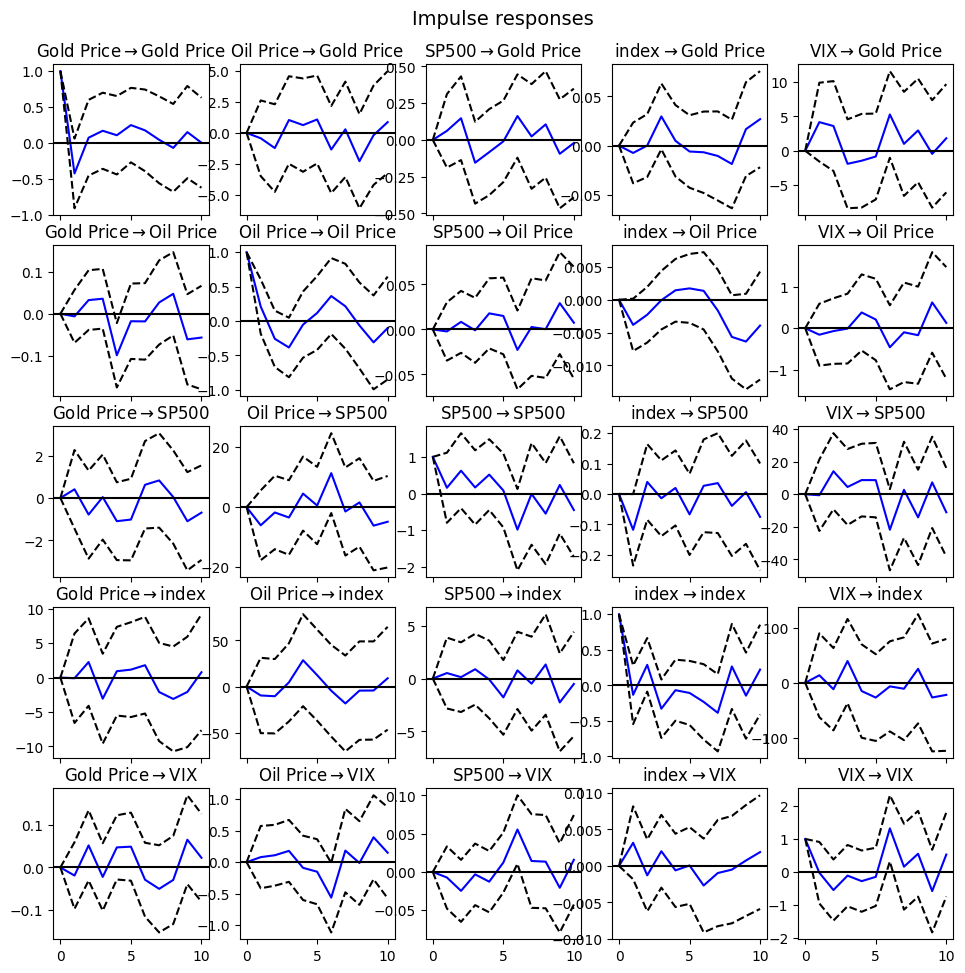

In [16]:
# Load and prepare the data
var_data = merged_df[['Gold Price', 'Oil Price', 'SP500', 'index', 'VIX']]
var_data_diff = var_data.diff().dropna()
full_range = pd.date_range(start=var_data.index.min(), end=var_data.index.max(), freq='W-SUN')
var_data_diff = var_data_diff.reindex(full_range).ffill().bfill()

# Function to perform stationarity test and print results
def adf_check(series):
    result = adfuller(series)
    p_value = result[1]
    # Check if the series is stationary based on the p-value
    if p_value < 0.05:
        print(f'{series.name} stationarity p-value: {p_value:.4g} -> Stationary')
    else:
        print(f'{series.name} stationarity p-value: {p_value:.4g} -> Not Stationary')

# Check each series for stationarity
for col in var_data_diff.columns:
    adf_check(var_data_diff[col])

# Fit the VAR model
model = VAR(var_data_diff)
results = model.fit(maxlags=12, ic=None)  
irf = results.irf(10)
irf.plot(orth=False)
plt.show()

# Lasso regression

The provided code snippet outlines the use of both linear regression and Lasso regression on a financial dataset, employing Python's scikit-learn library. The analysis incorporates 'Gold Price', 'Oil Price', 'SP500', and now 'VIX' as independent variables, with 'index' serving as the dependent variable. The dataset is split into training and testing sets, with 20% of the data earmarked for testing, allowing for model validation on unseen data. A critical step involves standardizing the features using StandardScaler. This standardization is essential, particularly for Lasso regression, because it ensures that the regularization penalty, which can shrink some coefficients to zero, is applied uniformly across all coefficients.

Linear regression is initially applied to the scaled training data, evaluated by the R² score on the scaled test data. Lasso regression is then employed, introducing a penalty term that not only helps in reducing model complexity by shrinking some coefficients to zero but also performs feature selection. This method is beneficial in scenarios with potential multicollinearity among features or where the model might overfit.

Lasso regression utilizes 5-fold cross-validation, a robust approach that splits the training data into five segments, training the model on four segments and validating on one, rotating until each segment has been used for validation. This technique offers a comprehensive estimate of the model's performance and its ability to generalize across different data samples.

Upon completion, the script generates a DataFrame that summarizes and compares the outcomes from both regression models. It details the R² scores and the coefficients for each feature. This comparison not only illuminates the impact of Lasso's regularization on the coefficients but also underscores the importance of how these coefficients should be interpreted: they represent the change in the dependent variable for a one standard deviation change in the predictor, assuming all other variables are held constant. This standardized interpretation allows for direct comparison of the influence of each variable on the dependent variable, showcasing the significant predictors that remain impactful in the model.

The Lasso Regression model, while having a slightly lower R² score, performs feature selection by shrinking some coefficients more significantly. However, in this case, none of the coefficients have been shrunk to zero, indicating that each variable retains at least some explanatory power in the model, contributing to the prediction of the target variable. This suggests that Lasso can help in identifying and reducing the impact of less important variables, potentially improving model interpretability and generalization, while still recognizing the relevance of all included features.

In [18]:
# Define the independent variables X and the dependent variable y
X = merged_df[['Gold Price', 'Oil Price', 'SP500', 'VIX']]  # Independent variables
y = merged_df['index']  # Dependent variable

# Prepare the data for scikit-learn regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the variables (important for Lasso regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_score = linear_model.score(X_test_scaled, y_test)

# Lasso Regression with Cross-Validation
lasso_cv = LassoCV(cv=5, random_state=0)
lasso_cv.fit(X_train_scaled, y_train)
lasso_score = lasso_cv.score(X_test_scaled, y_test)
lasso_coeffs = lasso_cv.coef_

# Create a table to compare results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Lasso Regression'],
    'R^2 Score': [linear_score, lasso_score],
    'Intercept': [linear_model.intercept_, lasso_cv.intercept_],
    'Gold Price Coef': [linear_model.coef_[0], lasso_coeffs[0]],  
    'Oil Price Coef': [linear_model.coef_[1], lasso_coeffs[1]],  
    'SP500 Coef': [linear_model.coef_[2], lasso_coeffs[2]], 
    'VIX Coef': [linear_model.coef_[3], lasso_coeffs[3]]
})

print(results)

               Model  R^2 Score     Intercept  Gold Price Coef  \
0  Linear Regression   0.530382  19312.720825      -205.235019   
1   Lasso Regression   0.527493  19312.720825      -171.919366   

   Oil Price Coef   SP500 Coef    VIX Coef  
0     -834.979268  1643.293477  814.231896  
1     -802.875262  1585.311391  776.400133  


# Machine Learning with the method of Random Forest
This code integrates bootstrap techniques with the Random Forest machine learning model to enhance the prediction of a financial index based on market indicators such as 'Gold Price', 'Oil Price', 'SP500', and 'VIX'. Bootstrap sampling trains multiple Random Forest models on varied subsets of the training data to evaluate the variability and stability of model predictions, specifically using Mean Squared Error (MSE) across multiple iterations. Random Forest, an ensemble learning technique, constructs several decision trees to improve accuracy and prevent overfitting. The script evaluates model performance using metrics like MSE, RMSE, and R-squared, and optimizes through Grid Search. It also visualizes feature importance and the relationship between predicted and actual values, employing SHAP values to delve deeper into the influence of each feature on predictions, demonstrating a sophisticated approach to predictive analytics in financial forecasting.

This initial script demonstrates an advanced econometric analysis using machine learning techniques to predict the watch index based on several market indicators. The dataset, named merged_df, includes columns such as 'Gold Price', 'Oil Price', 'SP500', and 'VIX', which serve as features, while the target variable is 'index'. Initially, the dataset is split into training and test sets using the train_test_split method with an 80-20 ratio, ensuring that the model is tested on unseen data.

The script utilizes a bootstrap approach to enhance the robustness of a Random Forest model by training on multiple bootstrap samples. This is implemented in the bootstrap_random_forest function, which creates several subsets (bootstraps) of the original training set, trains a RandomForestRegressor on each, and evaluates the performance using Mean Squared Error (MSE) on the test set. 

After evaluating the bootstrap models, a 95% confidence interval for the MSE is calculated to provide statistical insights into the model's accuracy. Moreover, the script explores hyperparameter tuning through Grid Search using GridSearchCV, optimizing parameters like the number of trees in the forest (n_estimators), the maximum number of features considered for splitting a node (max_features), and others to enhance the model's performance. 

In particular: the parameter n_estimators determines the number of trees in the forest, where higher values typically improve model performance but increase training time. The max_features parameter specifies the maximum number of features considered for splitting a node in each tree, with options such as the square root of the total number of features, the base-2 logarithm of the total number of features, or using all features. The max_depth sets the maximum depth of each tree, helping to prevent overfitting, with None meaning nodes are expanded until all leaves contain fewer than a specified number of samples. The min_samples_split defines the minimum number of samples required to split a node, preventing further splits if a node has fewer samples than this value. Lastly, min_samples_leaf represents the minimum number of samples that must be present in a leaf node; lower values can lead to more complex models and potential overfitting. These parameters, optimized using Grid Search with cross-validation, enhance the performance and robustness of the Random Forest model. 

The best parameters found through Grid Search are then printed.

In [19]:
# Select the columns of interest
features = merged_df[['Gold Price', 'Oil Price', 'SP500', 'VIX']]
target = merged_df['index']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest on bootstrap samples and evaluate performance
def bootstrap_random_forest(X_train, y_train, X_test, y_test, num_samples=100):
    mse_scores = []
    
    # Use tqdm for the progress bar
    for i in tqdm(range(num_samples), desc="Bootstrapping Iterations"):
        # Generate a bootstrap sample
        X_bootstrap, y_bootstrap = resample(X_train, y_train, random_state=i)
        
        # Create and train the model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_bootstrap, y_bootstrap)
        
        # Evaluate the model on the test dataset
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    return np.array(mse_scores)

# Perform bootstrapping and obtain the model performance
mse_scores = bootstrap_random_forest(X_train, y_train, X_test, y_test, num_samples=1000)

# Calculate the 95% confidence interval for the MSE
conf_int = np.percentile(mse_scores, [2.5, 97.5])

print(f"95% confidence interval for MSE: {conf_int}")
print(f"Mean MSE: {np.mean(mse_scores)}")

# Define the parameters to optimize
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2', 0.5, None],  # Number of features to consider at each split
    'max_depth': [10, 20, 30, 40, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required to be at a leaf node
}

# Create the model
rf = RandomForestRegressor(random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Bootstrapping Iterations: 100%|█████████████| 1000/1000 [00:39<00:00, 25.28it/s]

95% confidence interval for MSE: [1074536.10302976 2785675.67564206]
Mean MSE: 1778850.943917273
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


After determining the best hyperparameters through a previous Grid Search, a RandomForestRegressor is instantiated with these optimized parameters and a fixed random state for reproducibility.

The optimized model is then trained on the designated training set and predictions are made on the test set. The model's performance is quantitatively assessed using the Mean Squared Error (MSE) metric, providing a measure of the prediction accuracy.

Further analysis includes evaluating the importance of each feature (e.g., 'Gold Price', 'Oil Price', 'SP500', 'VIX') in predicting the financial index. This is visualized through a bar plot, highlighting which market indicators most significantly impact the model's predictions.

Additionally, the script plots predicted values against actual values to visually assess the model's performance, with a line of perfect fit depicted to indicate ideal predictions.

MSE of the optimized model: 1434793.094118451
95% confidence interval for MSE: [1074536.10302976 2785675.67564206]
Average unoptimized MSE: 1778850.943917273


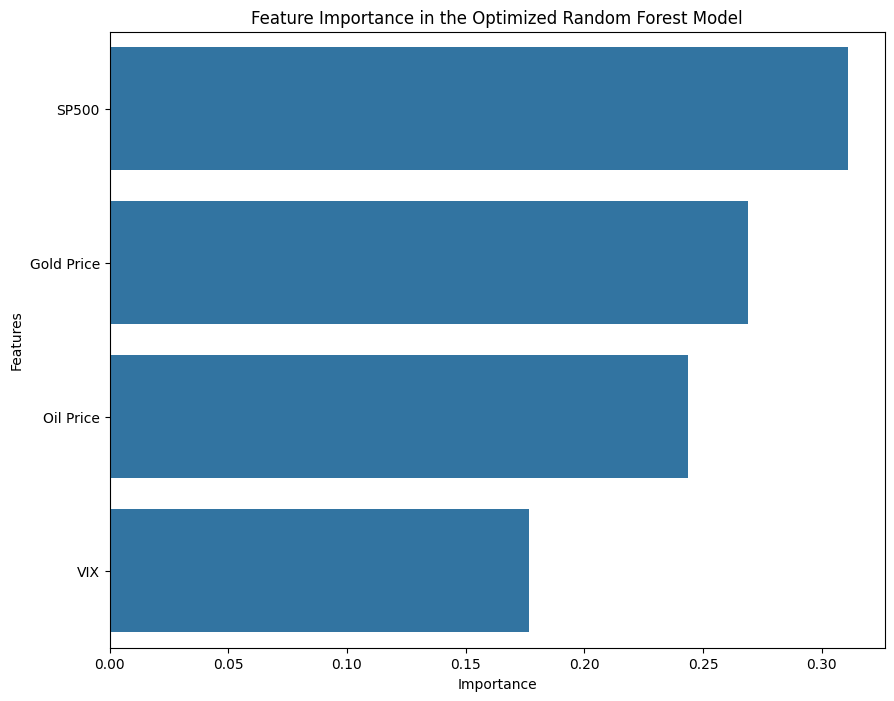

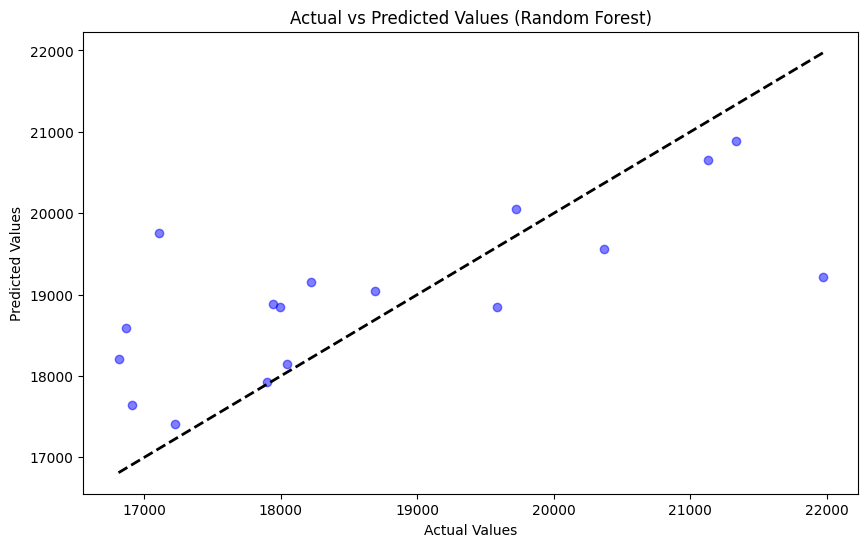

In [22]:
# Create the model with the best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Predict values on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"MSE of the optimized model: {mse}")

# Print the results
print(f"95% confidence interval for MSE: {conf_int}")
print(f"Average unoptimized MSE: {np.mean(mse_scores)}")

# Get feature importances
feature_importances = best_rf.feature_importances_
features_names = X_train.columns

# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'Features': features_names, 'Importance': feature_importances})

# Sort features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('Feature Importance in the Optimized Random Forest Model')
plt.show()

# Predict values on the test set using the optimized model
y_pred = best_rf.predict(X_test)

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.show()

Firstly, the following script defines evaluate_model, a function that takes a trained model and test data as input and computes several performance metrics: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and the R-squared value. These metrics offer a detailed perspective on the model's performance, indicating overall error magnitude (MSE, RMSE), average error magnitude (MAE), and the proportion of variance in the target variable explained by the model (R-squared).

Next, the script assesses the model using cross-validation with the cross_val_evaluate function, which evaluates the model stability and effectiveness over different subsets of the data. This method uses the cross_val_score function to perform 5-fold cross-validation, specifically calculating the negative MSE, which is then converted to positive values for interpretability. The results, including the mean MSE from cross-validation, provide insight into the model’s performance consistency across different data splits.

The residuals (the differences between actual and predicted values) are also computed and visualized using a histogram, providing insights into the distribution of the prediction errors. A symmetric, bell-shaped histogram centered around zero would suggest good model performance with errors distributed normally around the mean.

Evaluation Results: {'MSE': 1528389.981279615, 'RMSE': 1236.2807048885036, 'MAE': 930.1618469684232, 'R-squared': 0.45231335053810573}
MSE scores from cross-validation: [15757264.76672897  1411402.91097953   599946.66178081  4713225.18672013
  9932210.69839162]
Mean CV MSE: 6482810.044920212


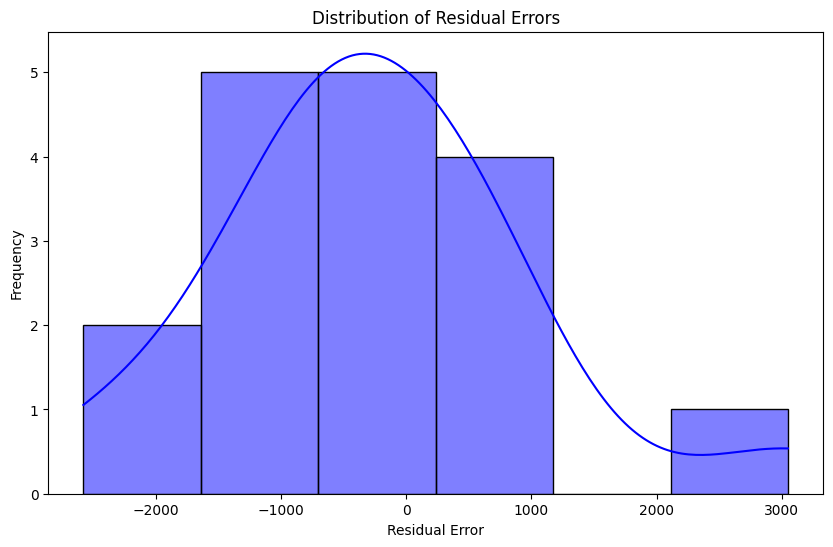

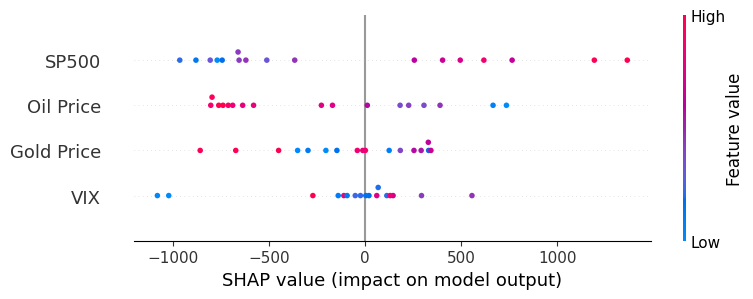

In [22]:
# Function to evaluate the model with multiple metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R-squared': r2}

# Evaluate the optimized model
evaluation_results = evaluate_model(best_rf, X_test, y_test)
print(f"Evaluation Results: {evaluation_results}")

# Function to evaluate the model using cross-validation
def cross_val_evaluate(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    mse_scores = -scores  # Invert the negative mean squared error values
    return mse_scores

# Evaluate the optimized model
cv_scores = cross_val_evaluate(best_rf, features, target)
print(f"MSE scores from cross-validation: {cv_scores}")
print(f"Mean CV MSE: {np.mean(cv_scores)}")

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.xlabel('Residual Error')
plt.ylabel('Frequency')
plt.title('Distribution of Residual Errors')
plt.show()

# Calculate SHAP values
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Plot feature importances
shap.summary_plot(shap_values, X_test)

In the context of evaluating a machine learning model using both bootstrap methods and cross-validation, the mean MSE from cross-validation is higher than from bootstrap sampling. This difference can be attributed to the distinct ways these methods handle data: bootstrap samples with replacement, potentially providing more varied training sets, while cross-validation systematically uses each data point exactly once, exposing the model to all data variations. Bootstrap might show lower MSE due to repeated exposure to specific data points, potentially reducing the impact of outliers. In contrast, cross-validation offers a more comprehensive assessment by evaluating model stability and generalization across all data segments, often revealing higher MSE if the model struggles with any part of the data. This highlights the importance of choosing the right evaluation method to accurately reflect the model's performance in real-world scenarios.

The histogram of residuals shows the distribution of differences between actual and predicted values. While somewhat symmetric, it has a slight right skew, indicating potential outliers affecting predictions.

The SHAP summary plot highlights the impact of each feature on the model's output, with SP500 having the most significant impact, followed by Oil Price, Gold Price, and VIX.

# Conclusion
In conclusion, the analysis of correlations and regression models based on the data of collectible watches in Monte Carlo reveals an intriguing scenario for investors. The results suggest that watches may represent a sound investment. Particularly noteworthy is the observation of positive VIX coefficients in both linear and Lasso regression models. This detail highlights how watches, in this specific context, are perceived as a safe-haven asset: during periods of high market volatility and uncertainty, investors tend to turn to tangible assets with a proven historical value, such as luxury watches.

The employment of the Random Forest model has further solidified these observations, revealing how features related to financial market trends, such as the SP500 and VIX, significantly impact the predictions of watch values, with SP500 having the most pronounced effect. The model demonstrated significant predictive power, with a substantially reduced Mean Squared Error (MSE) compared to unoptimized models. This confirms the hypothesis that high-end watches can serve as secure and stable investments during financial turmoil.

This analysis, therefore, provides valuable insights for investors considering diverse assets in their portfolios, emphasizing luxury watches not only as objects of aesthetic and historical pleasure but also as strategic financial instruments in uncertain times. Advanced modeling through Random Forest highlights the importance of considering various market factors and how they may influence investments in luxury goods, further confirming the role of watches as valuable assets during periods of economic uncertainty.